In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import io
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
from sklearn.model_selection import train_test_split
from PIL import Image
from datetime import datetime


# Custom modules and packages
import params.siamese
import traversalcost.utils
from dataset import SiameseNetworkDataset
from model import SiameseNetwork
from loss import SiameseLoss
from train import train
from validate import validate
from test import test
from result import parameters_table, generate_log

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.siamese.LEARNING

## Prepare data

In [3]:
# Create a Dataset for training
train_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for validation
# (same as training here since no transformation is applied to the data,
# train and validation sets will be split later)
val_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for testing
test_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_test.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Set the train dataset size
train_size = params.siamese.TRAIN_SIZE/(1-params.siamese.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [4]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [5]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (302 samples)
15.0 % of the data for validation (65 samples)
15.0 % of the data for testing (65 samples)


## GPU?

In [6]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [7]:
# Create a model
nb_input_features = len(train_set[0][0])
model = SiameseNetwork(input_size=nb_input_features).to(device=device)

In [8]:
# Create a loss function
criterion = SiameseLoss(margin=LEARNING_PARAMS["margin"]).to(device=device)

In [9]:
# Define the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

# Create tensors to store the loss values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Create tensors to store the accuracy values
accuracy_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss, train_accuracy = train(model,
                                       device,
                                       train_loader,
                                       optimizer,
                                       criterion,
                                       epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model,
                                      device,
                                      val_loader,
                                      criterion,
                                      epoch) 
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy

Epoch 0 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.26batch/s, batch_loss=0.131]


Train loss:  0.14126766296593765
Validation loss:  0.12712083674139446
Train accuracy:  72.18543046357615
Validation accuracy:  78.46153846153847


Epoch 1 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.56batch/s, batch_loss=0.034] 


Train loss:  0.10593993706922782
Validation loss:  0.08017384219500753
Train accuracy:  77.81456953642385
Validation accuracy:  81.53846153846153


Epoch 2 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.90batch/s, batch_loss=0.152] 


Train loss:  0.07588020207262353
Validation loss:  0.08377084467146131
Train accuracy:  81.45695364238411
Validation accuracy:  80.0


Epoch 3 [val]: 100%|██████████| 9/9 [00:00<00:00, 11.62batch/s, batch_loss=0.146] 


Train loss:  0.06780246919707249
Validation loss:  0.07786197173926565
Train accuracy:  82.45033112582782
Validation accuracy:  86.15384615384616


Epoch 4 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.34batch/s, batch_loss=0]     


Train loss:  0.06184279036365057
Validation loss:  0.0596378528409534
Train accuracy:  83.44370860927152
Validation accuracy:  83.07692307692308


Epoch 5 [val]: 100%|██████████| 9/9 [00:00<00:00, 11.25batch/s, batch_loss=0.0154] 


Train loss:  0.055802674032747746
Validation loss:  0.05859509358803431
Train accuracy:  85.09933774834437
Validation accuracy:  84.61538461538461


Epoch 6 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.00batch/s, batch_loss=0]     


Train loss:  0.05126256696683796
Validation loss:  0.054311501069201365
Train accuracy:  85.76158940397352
Validation accuracy:  84.61538461538461


Epoch 7 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.13batch/s, batch_loss=0.0566] 


Train loss:  0.04789469459731328
Validation loss:  0.05853408026612467
Train accuracy:  86.75496688741723
Validation accuracy:  84.61538461538461


Epoch 8 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.69batch/s, batch_loss=0]      


Train loss:  0.04498360320729645
Validation loss:  0.05003724650790294
Train accuracy:  88.0794701986755
Validation accuracy:  84.61538461538461


Epoch 9 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.13batch/s, batch_loss=0]     


Train loss:  0.04056434879863733
Validation loss:  0.04923363174829218
Train accuracy:  89.0728476821192
Validation accuracy:  84.61538461538461


Epoch 10 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.67batch/s, batch_loss=0]      


Train loss:  0.03674518359874032
Validation loss:  0.045008078010545835
Train accuracy:  91.72185430463576
Validation accuracy:  86.15384615384616


Epoch 11 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.17batch/s, batch_loss=0]     


Train loss:  0.033239310429627564
Validation loss:  0.04276253096759319
Train accuracy:  92.05298013245033
Validation accuracy:  86.15384615384616


Epoch 12 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.34batch/s, batch_loss=0]     


Train loss:  0.029085416028178053
Validation loss:  0.04082343334125148
Train accuracy:  92.71523178807946
Validation accuracy:  83.07692307692308


Epoch 13 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.42batch/s, batch_loss=0]     


Train loss:  0.02709564189181516
Validation loss:  0.03619601567172342
Train accuracy:  93.37748344370861
Validation accuracy:  89.23076923076923


Epoch 14 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.03batch/s, batch_loss=0.197]  


Train loss:  0.027221565772044033
Validation loss:  0.05502990633249283
Train accuracy:  92.71523178807946
Validation accuracy:  86.15384615384616


Epoch 15 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.05batch/s, batch_loss=0]      


Train loss:  0.021476971671769495
Validation loss:  0.03509709321790271
Train accuracy:  94.70198675496688
Validation accuracy:  89.23076923076923


Epoch 16 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.09batch/s, batch_loss=0]      


Train loss:  0.02186815514180221
Validation loss:  0.027716635002030268
Train accuracy:  94.37086092715232
Validation accuracy:  90.76923076923077


Epoch 17 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.33batch/s, batch_loss=0.265]  


Train loss:  0.017151727365623964
Validation loss:  0.04957029140657849
Train accuracy:  95.03311258278146
Validation accuracy:  90.76923076923077


Epoch 18 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.92batch/s, batch_loss=0]      


Train loss:  0.016059488744327898
Validation loss:  0.022718677918116253
Train accuracy:  95.36423841059603
Validation accuracy:  90.76923076923077


Epoch 19 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.31batch/s, batch_loss=0]     


Train loss:  0.015286646660809455
Validation loss:  0.016891698870393965
Train accuracy:  96.02649006622516
Validation accuracy:  93.84615384615384


Epoch 20 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.50batch/s, batch_loss=0]     


Train loss:  0.01304716058075428
Validation loss:  0.013453113122118844
Train accuracy:  96.35761589403974
Validation accuracy:  95.38461538461539


Epoch 21 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.53batch/s, batch_loss=0]      


Train loss:  0.009415394234422007
Validation loss:  0.010183539448512925
Train accuracy:  97.35099337748345
Validation accuracy:  95.38461538461539


Epoch 22 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.68batch/s, batch_loss=0]       


Train loss:  0.008408995467777314
Validation loss:  0.010864968929025862
Train accuracy:  98.01324503311258
Validation accuracy:  95.38461538461539


Epoch 23 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.08batch/s, batch_loss=0]      


Train loss:  0.008054877557840786
Validation loss:  0.007371637556287978
Train accuracy:  98.67549668874172
Validation accuracy:  98.46153846153847


Epoch 24 [val]: 100%|██████████| 9/9 [00:00<00:00, 11.95batch/s, batch_loss=0]       


Train loss:  0.006199411018506477
Validation loss:  0.0063491856886280906
Train accuracy:  99.33774834437087
Validation accuracy:  98.46153846153847


Epoch 25 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.43batch/s, batch_loss=0]      


Train loss:  0.004940021194909748
Validation loss:  0.007114343759086397
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 26 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.01batch/s, batch_loss=0]     


Train loss:  0.004733513942674587
Validation loss:  0.006331219441360897
Train accuracy:  99.66887417218543
Validation accuracy:  98.46153846153847


Epoch 27 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.46batch/s, batch_loss=0]       


Train loss:  0.00343195422503509
Validation loss:  0.0020487563063700995
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 28 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.69batch/s, batch_loss=0]      


Train loss:  0.002642518154492504
Validation loss:  0.004116145376529958
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 29 [val]: 100%|██████████| 9/9 [00:00<00:00, 11.90batch/s, batch_loss=0]       


Train loss:  0.0021133139533431908
Validation loss:  0.002017348590824339
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 30 [val]: 100%|██████████| 9/9 [00:00<00:00, 11.51batch/s, batch_loss=0]      


Train loss:  0.0014408598408887261
Validation loss:  0.002258432408173879
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 31 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.57batch/s, batch_loss=0]      


Train loss:  0.0016295430005380982
Validation loss:  0.003851839237742954
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 32 [val]: 100%|██████████| 9/9 [00:00<00:00, 11.98batch/s, batch_loss=0]       


Train loss:  0.00164413893301236
Validation loss:  0.00267689178387324
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 33 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.16batch/s, batch_loss=0]       


Train loss:  0.002062230551688883
Validation loss:  0.0026499188194672265
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 34 [val]: 100%|██████████| 9/9 [00:00<00:00, 11.32batch/s, batch_loss=0]      


Train loss:  0.0014065020766697433
Validation loss:  0.0023531499836179945
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 35 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.22batch/s, batch_loss=0]      


Train loss:  0.0018650686160024059
Validation loss:  0.005686430674460199
Train accuracy:  99.66887417218543
Validation accuracy:  98.46153846153847


Epoch 36 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.47batch/s, batch_loss=0]      


Train loss:  0.0028971340507268906
Validation loss:  0.002380260162883335
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 37 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.20batch/s, batch_loss=0]       


Train loss:  0.0019411180952661916
Validation loss:  0.001429987864361869
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 38 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.36batch/s, batch_loss=0]      


Train loss:  0.0023123178827135185
Validation loss:  0.0020599129299322763
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 39 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.91batch/s, batch_loss=0]      


Train loss:  0.001685584814128417
Validation loss:  0.003724097791645262
Train accuracy:  99.66887417218543
Validation accuracy:  98.46153846153847


Epoch 40 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.58batch/s, batch_loss=0.152]  


Train loss:  0.0014875486100974836
Validation loss:  0.017526034265756607
Train accuracy:  99.66887417218543
Validation accuracy:  98.46153846153847


Epoch 41 [val]: 100%|██████████| 9/9 [00:00<00:00, 11.75batch/s, batch_loss=0]       


Train loss:  0.0013279776628080167
Validation loss:  0.0016454618631137742
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 42 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.11batch/s, batch_loss=0]      


Train loss:  0.0026038378219757426
Validation loss:  0.0011803238756126827
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 43 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.75batch/s, batch_loss=0]       


Train loss:  0.00204023356108289
Validation loss:  0.00018185956610573662
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 44 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.51batch/s, batch_loss=0]      


Train loss:  0.001651746760073461
Validation loss:  0.0009793750941753387
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 45 [val]: 100%|██████████| 9/9 [00:00<00:00, 13.23batch/s, batch_loss=0]       


Train loss:  0.0015709948676981423
Validation loss:  9.835635622342427e-05
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 46 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.64batch/s, batch_loss=0]      


Train loss:  0.001392596156189316
Validation loss:  0.0003860019561317232
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 47 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.78batch/s, batch_loss=0]      


Train loss:  0.0012348972653087817
Validation loss:  0.0007129304317964448
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 48 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.13batch/s, batch_loss=0]      


Train loss:  0.0009700218705754531
Validation loss:  0.001215798987282647
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


Epoch 49 [val]: 100%|██████████| 9/9 [00:00<00:00, 12.53batch/s, batch_loss=0]       

Train loss:  0.0015763315911355772
Validation loss:  0.0006769717567496829
Train accuracy:  99.66887417218543
Validation accuracy:  100.0


### Visualization

Text(0.5, 0, 'Epoch')

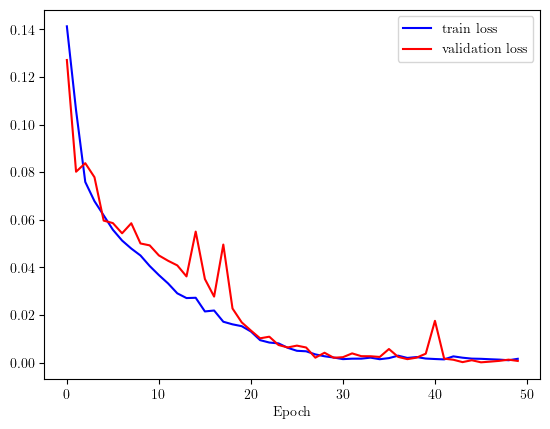

In [10]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

figure = plt.figure()

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

# # Converts the figure to an image
# learning_curve = io.BytesIO()
# figure.savefig(learning_curve, format="png")
# learning_curve.seek(0)

# # Create a PIL image from the image stream
# learning_curve = Image.open(learning_curve)

Text(0.5, 0, 'Epoch')

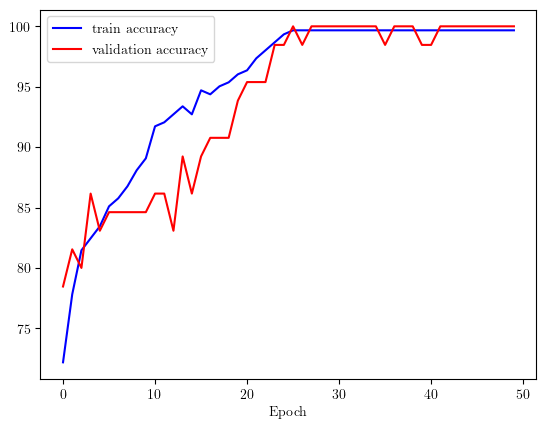

In [11]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

## Testing

In [12]:
# Test the model
test_loss, test_accuracy = test(model,
                                device,
                                test_loader,
                                criterion)

print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

Test loss:  0.016393287314309016
Test accuracy:  95.38461538461539


## Compute and display traversal costs

In [13]:
# Compute the traversal costs from the features of the dataset
costs_df = traversalcost.utils.compute_traversal_costs(
    dataset=params.siamese.DATASET,
    cost_function=model.to(device="cpu"),
    to_tensor=True
)

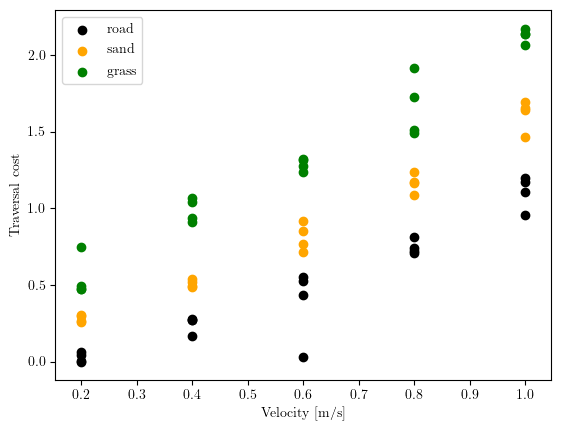

In [14]:
# Display the traversal costs
cost_graph = traversalcost.utils.display_traversal_costs(costs_df)

## Generate a log directory

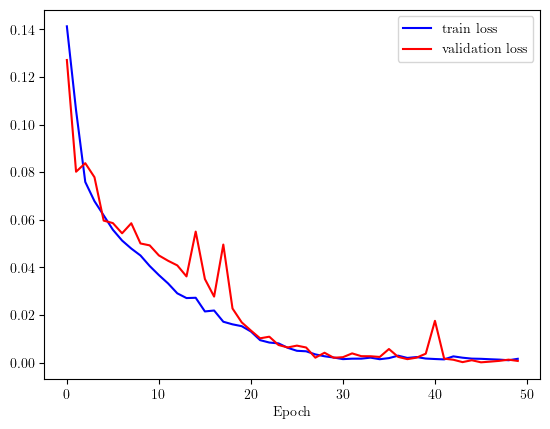

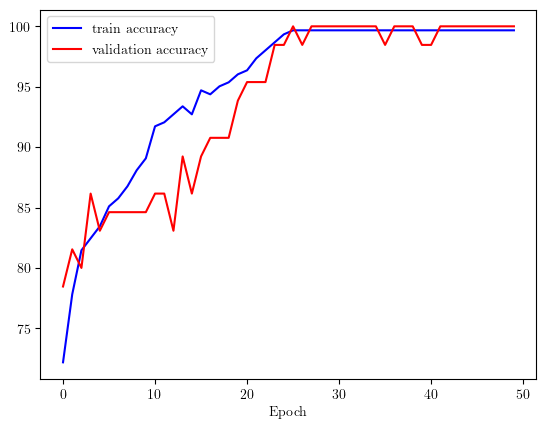

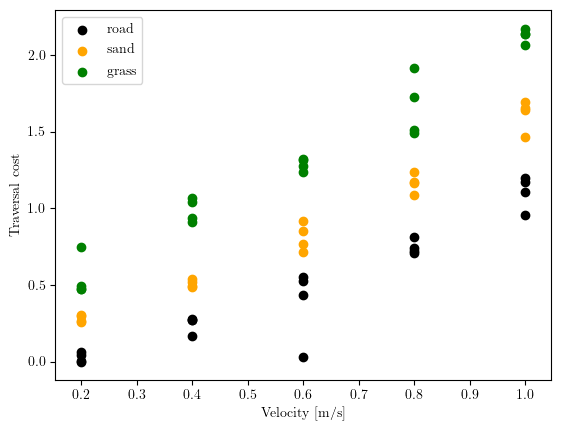

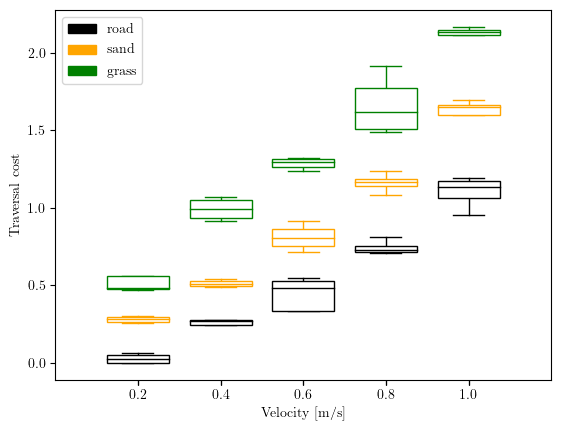

In [15]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.siamese.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.siamese.LOG_DIR:
    results_directory = "logs/_" +\
                        params.siamese.LOG_DIR
else:
    results_directory = "logs/_" +\
                        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
generate_log(dataset_directory=params.siamese.DATASET,
             results_directory=results_directory,
             test_loss=test_loss,
             test_accuracy=test_accuracy,
             parameters_table=params_table,
             model=model,
             loss_values=loss_values,
             accuracy_values=accuracy_values)